# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
# Enable inline plotting
%matplotlib inline

# Backport python3 division behavior
from __future__ import division

from urllib import urlencode
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

import pytz
from pprint import pprint

from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set plotting configuration
sns.set_palette('deep', desat=.8)
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (16,5)})
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [2]:
import pvlib
import rdtools

print pvlib.__version__
print rdtools.__version__

/Users/traveler/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.4.4
1.0.1+28.gaf57155


# 1. <b>Standardize</b>

Please download the annual csv data for system with system id 39, using the PVDAQ API, and store the csv file in the folder:
./rdtools/docs/

https://developer.nrel.gov/docs/solar/pvdaq-v3/data_file/

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [3]:
systemid=39
api_key='ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'
pvdaq_metadata_url = 'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=' + str(systemid) + '&api_key=' + api_key

In [4]:
pvdaq_metadata_url

'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=39&api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'

In [5]:
import urllib2
import xmltodict
import xml.etree.ElementTree as et

file = urllib2.urlopen(pvdaq_metadata_url)
tree = et.parse(file)
file.close()

root = tree.getroot()



avail_year = [int(avail_year.text) for avail_year in root.iter('available-year')]
start_year = avail_year[0]
end_year = avail_year[-1]
inverter_mfg = [str(inv_mfg.text) for inv_mfg in root.iter('inverter-mfg')][0]
inverter_model = [str(inv_model.text) for inv_model in root.iter('inverter-model')][0]
module_mfg = [str(mod_mfg.text) for mod_mfg in root.iter('module-mfg')][0]
module_model = [str(mod_model.text) for mod_model in root.iter('module-model')][0]
power = [float(site_power.text) for site_power in root.iter('site-power')][0]
area = [float(site_area.text) for site_area in root.iter('site-area')][0]
azimuth = [float(site_azimuth.text) for site_azimuth in root.iter('site-azimuth')][0]
elevation = [float(site_elevation.text) for site_elevation in root.iter('site-elevation')][0]
lat = [float(site_lat.text) for site_lat in root.iter('site-latitude')][0]
lon = [float(site_lon.text) for site_lon in root.iter('site-longitude')][0]
lon = -lon
tilt = [float(site_tilt.text) for site_tilt in root.iter('site-tilt')][0]
name = [str(name_priv.text) for name_priv in root.iter('name-private')][0]

In [6]:
avail_year

[1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

In [7]:
year = 2002
pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)

In [8]:
pvdaq_ann_csv_url

'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd&system_id=39&year=2002'

In [9]:
df = pd.DataFrame()
#list_years = avail_year
list_years = [2000,2001,2002,2003]
for year in list_years:
    pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)
    data = pd.read_csv(pvdaq_ann_csv_url)
    df = df.append(data)
    

In [10]:
df.head()

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,dc_pos_current,dc_pos_voltage,dc_power,inverter_temp,module_temp_1,module_temp_2,module_temp_3,module_temp_4,module_temp_5,module_temp_6,module_temp_7,poa_irradiance
0,39,2000-11-14 14:45:00,1.756,590.2,203.2,2.710,5.747,57.81,315.2,5.872,21.10,9.230,21.91,21.68,21.35,21.88,20.15,179.300
1,39,2000-11-14 15:00:00,3.291,546.5,203.3,2.740,10.160,52.52,531.4,6.629,19.55,8.800,20.01,20.27,19.33,20.34,18.59,615.000
2,39,2000-11-14 15:15:00,2.734,483.6,203.3,2.280,7.880,54.44,424.0,8.130,16.57,7.640,17.01,16.87,16.43,17.07,15.68,480.400
3,39,2000-11-14 15:30:00,1.047,416.9,201.6,2.152,3.466,61.02,211.5,8.800,15.67,7.170,16.17,16.09,15.65,16.22,14.85,-14.640
4,39,2000-11-14 15:45:00,1.080,347.7,201.4,1.925,3.503,60.47,211.5,9.020,14.59,6.855,15.13,15.16,14.35,15.76,14.16,-0.725


In [11]:
type(df['Date-Time'])

pandas.core.series.Series

In [12]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

In [13]:
df.set_index('Date-Time', inplace=True)

In [14]:
df.index

DatetimeIndex(['2000-11-14 14:45:00', '2000-11-14 15:00:00',
               '2000-11-14 15:15:00', '2000-11-14 15:30:00',
               '2000-11-14 15:45:00', '2000-11-14 16:00:00',
               '2000-11-14 16:15:00', '2000-11-14 16:30:00',
               '2000-11-14 16:45:00', '2000-11-14 17:00:00',
               ...
               '2003-06-09 11:15:00', '2003-06-09 11:30:00',
               '2003-06-09 11:45:00', '2003-06-09 12:00:00',
               '2003-06-09 12:15:00', '2003-06-09 12:30:00',
               '2003-06-09 12:45:00', '2003-06-09 13:00:00',
               '2003-06-09 13:15:00', '2003-06-09 13:30:00'],
              dtype='datetime64[ns]', name=u'Date-Time', length=58869, freq=None)

In [15]:
df = df.resample('15T').mean()

In [16]:
print pd.infer_freq(df.index)

15T


In [17]:
timezone = pytz.timezone("Etc/GMT+7")
df.index = df.index.tz_localize(timezone)

In [18]:
module_temp = df.filter(regex=("module_temp*"))
module_temp = module_temp.median(axis=1)
df['module_temperature'] = module_temp

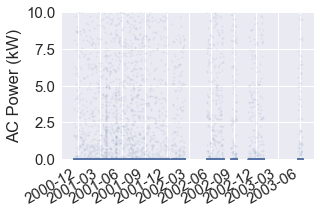

In [19]:
# downsample
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.ac_power, 'o', alpha = 0.1)
ax.set_ylim(0,10)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

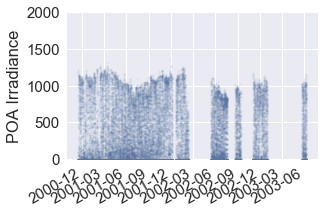

In [20]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa_irradiance, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

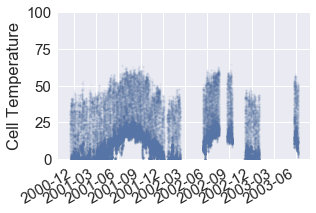

In [21]:
# plot the cell temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df.module_temperature, 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

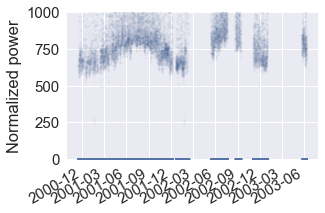

In [22]:
# Metadata
pdc = 1.4 # System size in kW

pvwatts_kws = {"poa_global" : df.poa_irradiance,
              "P_ref" : pdc,
              "T_cell" : df.module_temperature,
              "G_ref" : 1000,
              "T_ref" : 20,
              "gamma_pdc" : -0.00506}

normalized = rdtools.normalize_with_pvwatts(df.ac_power, pvwatts_kws)


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [23]:
normalized.head(n=50)

Date-Time
2000-11-14 14:45:00-07:00      2367.378639
2000-11-14 15:00:00-07:00       633.285071
2000-11-14 15:15:00-07:00       706.776974
2000-11-14 15:30:00-07:00    -19904.451699
2000-11-14 15:45:00-07:00   -333433.955205
2000-11-14 16:00:00-07:00      1843.172857
2000-11-14 16:15:00-07:00      1277.025777
2000-11-14 16:30:00-07:00      -401.357458
2000-11-14 16:45:00-07:00       -53.911075
2000-11-14 17:00:00-07:00        -0.000000
2000-11-14 17:15:00-07:00        -0.000000
2000-11-14 17:30:00-07:00        -0.000000
2000-11-14 17:45:00-07:00        -0.000000
2000-11-14 18:00:00-07:00        -0.000000
2000-11-14 18:15:00-07:00        -0.000000
2000-11-14 18:30:00-07:00        -0.000000
2000-11-14 18:45:00-07:00        -0.000000
2000-11-14 19:00:00-07:00        -0.000000
2000-11-14 19:15:00-07:00        -0.000000
2000-11-14 19:30:00-07:00        -0.000000
2000-11-14 19:45:00-07:00        -0.000000
2000-11-14 20:00:00-07:00        -0.000000
2000-11-14 20:15:00-07:00        -0.000000
2

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


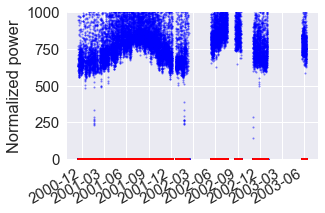

In [24]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future

df['normalized'] = normalized
#filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa_irradiance>200))
filter_criteria = ((df['normalized']>500) & (df['normalized']<1000) & (df.poa_irradiance>200))

filtered = df[filter_criteria]['normalized']




#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', color='b', alpha = 0.5)
ax.plot(filtered.index, filtered, 'o', color='r', alpha = 0.5)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [25]:
filtered

Date-Time
2000-11-14 15:00:00-07:00    0.794990
2000-11-14 15:15:00-07:00    0.887247
2000-11-15 09:00:00-07:00    0.860861
2000-11-15 09:15:00-07:00    0.750504
2000-11-15 09:45:00-07:00    0.824879
2000-11-15 10:00:00-07:00    0.798734
2000-11-15 10:15:00-07:00    0.798300
2000-11-15 10:30:00-07:00    0.853448
2000-11-15 10:45:00-07:00    0.964304
2000-11-15 11:30:00-07:00    0.937540
2000-11-15 11:45:00-07:00    0.816045
2000-11-15 12:00:00-07:00    0.791848
2000-11-15 12:15:00-07:00    0.795367
2000-11-15 12:30:00-07:00    0.804750
2000-11-15 12:45:00-07:00    0.801214
2000-11-15 15:15:00-07:00    0.805277
2000-11-15 15:30:00-07:00    0.760131
2000-11-15 15:45:00-07:00    0.815811
2000-11-15 16:00:00-07:00    1.224784
2000-11-16 08:00:00-07:00    0.743228
2000-11-16 08:15:00-07:00    0.705513
2000-11-16 08:30:00-07:00    0.703669
2000-11-16 08:45:00-07:00    0.700030
2000-11-16 09:00:00-07:00    0.710076
2000-11-16 09:15:00-07:00    0.737318
2000-11-16 09:30:00-07:00    0.744844
20

# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  



In [26]:
ols_rd, ols_ci, ols_info = rdtools.degradation.degradation_ols(filtered)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year''' % (ols_rd, ols_ci[0], ols_ci[1])

# yoy = rdtools.degradation.degradation_year_on_year(filtered)
# print "degradation_year_on_year", yoy

The degradation rate calculated with ols is 2.44 %/year
with a confidence interval of 2.27 to 2.60 %/year


In [27]:
filtered.index

DatetimeIndex(['2000-11-14 15:00:00-07:00', '2000-11-14 15:15:00-07:00',
               '2000-11-15 09:00:00-07:00', '2000-11-15 09:15:00-07:00',
               '2000-11-15 09:45:00-07:00', '2000-11-15 10:00:00-07:00',
               '2000-11-15 10:15:00-07:00', '2000-11-15 10:30:00-07:00',
               '2000-11-15 10:45:00-07:00', '2000-11-15 11:30:00-07:00',
               ...
               '2003-06-09 11:00:00-07:00', '2003-06-09 11:15:00-07:00',
               '2003-06-09 11:30:00-07:00', '2003-06-09 11:45:00-07:00',
               '2003-06-09 12:00:00-07:00', '2003-06-09 12:15:00-07:00',
               '2003-06-09 12:30:00-07:00', '2003-06-09 12:45:00-07:00',
               '2003-06-09 13:00:00-07:00', '2003-06-09 13:15:00-07:00'],
              dtype='datetime64[ns, Etc/GMT+7]', name=u'Date-Time', length=14110, freq=None)

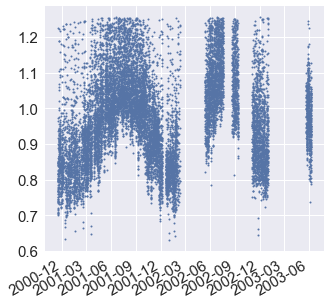

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
fig.autofmt_xdate()

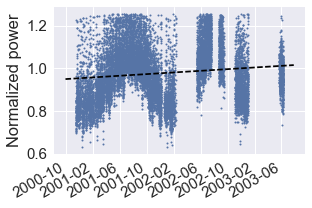

In [29]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

#ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [30]:
# Plot the year-on-year distribution
# YoY_filtered1 = yoy['YoY_filtered']
# YOY_median = yoy['Rd_median']
# plt.hist(YoY_filtered1, alpha=0.5, label='YOY', bins=int(YoY_filtered1.__len__()/4))
# plt.axvline(x=YOY_median, color='black', linestyle='dashed', linewidth=3)
# #plt.legend(loc='upper right')
# plt.title('Year-on-Year 15-minute Distribution \n Data outside +/-100 removed')   
# plt.tight_layout(w_pad=1, h_pad=2.0)
# plt.xlabel('Annual degradation (%)')